# Kernel powstal na podstawie tutorialu [Machine Learningu ](www.kaggle.com/dansbecker/learn-machine-learning) na Kaggle

## Zawiera glowne kroki zawarte w Intermediate Machine Learning z kilkoma zmianami, by operowac na tych samych danych i nie powtarzac tych samych operacji w krokach 1-4. Czesc 7. operuje na innym datasetcie.
### Zawiera:

1.  Oczyszczanie danych i imputacje

2. One-hot encoding

3. XGBoosting

4. Wykresy czesciowej zaleznosci (Partial Dependence Plots)

5. Tworzenie PIPELINE

6. Cross Validation

7. Data Leakage

# 1. Oczyszczanie danych z pustych wartości przez usuwanie kolumn lub imputację

In [1]:
import pandas as pd
melb_data = pd.read_csv('../input/melbourne-housing-snapshot/melb_data.csv') #wczytanie danych

from sklearn.ensemble import RandomForestRegressor #las losowy
from sklearn.metrics import mean_absolute_error #MAE - do obliczen absolutnego bledu
from sklearn.model_selection import train_test_split #podzial na train i test

melb_target=melb_data.Price #nasz target - cena domu
melb_predictors=melb_data.drop(['Price'], axis=1) #nasze cechy, ktore uzywamy do przewidywania ceny (wyrzucenie kolumny z cena)
 
#melb_numeric_predictors = melb_predictors.select_dtypes(exclude=['object']) #odrzucenie nienumreycznych wartosci

In [2]:
#Mala modyfikacja, by zrealizowac krok 2 z tutorialu level 2 One-hot encoding, podzielilem train_X i val_X na wartosci numeryczne i nienumeryczne
#by po imputacji moc dalej operowac na pelnym zbiorze i przeprowadzic one-hot encoding

#train_X, val_X, train_y, val_y = train_test_split(melb_numeric_predictors, melb_target, random_state=0) #podzial na train i test, pseudolosowo
train_X_all, val_X_all, train_y, val_y = train_test_split(melb_predictors, melb_target, random_state=0) #podzial na train i test, pseudolosowo

train_X = train_X_all.select_dtypes(exclude=['object'])#numeryczne wartosci
val_X=val_X_all.select_dtypes(exclude=['object']) #numeryczne wartosci

train_X_str=train_X_all.select_dtypes(include=['object']) #wartosci nienumeryczne
val_X_str=val_X_all.select_dtypes(include=['object']) #wartosci nienumeryczne

In [3]:
def score_dataset(train_X, val_X, train_y, val_y):
    '''Funkcja zwaracaja MAE na podstawie wprowadzonych train i testow. Predykcja z uzyciem lasu losowego'''
    melbourne_model=RandomForestRegressor() #las losowy jako model
    melbourne_model.fit(train_X, train_y) #trening 
    val_predictions=melbourne_model.predict(val_X) #predykcja na zbiorze testowym
    return mean_absolute_error(val_y, val_predictions) #obliczenie MAE

In [4]:
#TEST MODELU Z ODRZUCENIEM KOLUMN ZWIERAJACYCH PUSTE KOMORKI
#train_data.dropna(axis=0, subset=['SalePrice'], inplace=True) #wyrzucenie wierszy, ktore nie maja podanej ceny
cols_with_missing = [col for col in train_X.columns #przypisanie, w ktorych kolumnach brakuje danych
                                 if train_X[col].isnull().any()]
reduced_X_train = train_X.drop(cols_with_missing, axis=1)#wyrzucenie kolum z brakujacymi danymi z train
reduced_X_test  = val_X.drop(cols_with_missing, axis=1)#jw tylko z test
print("Mean Absolute Error z wyrzuceniem kolumn:")
print(score_dataset(reduced_X_train, reduced_X_test, train_y, val_y))

Mean Absolute Error z wyrzuceniem kolumn:
189617.25472754048


In [5]:
#TEST MODELU DLA IMPUTACJI W PUSTE MIEJSCA
from sklearn.impute import SimpleImputer #wczytanie imputora
my_imputer = SimpleImputer()
imputed_X_train = my_imputer.fit_transform(train_X)#imputacja pustych pol w zbiorze treningowym
imputed_X_test = my_imputer.transform(val_X)#imputacja pustych pol w zbiorze testowym
print("Mean Absolute Error z imputacji:")
print(score_dataset(imputed_X_train, imputed_X_test, train_y, val_y)) #obliczenie MAE

Mean Absolute Error z imputacji:
178835.72513500243


In [6]:
#TEST MODELU DLA IMPUTACJI W PUSTE MIEJSCA + WSKAZANIE KOLUMN, GDZIE SĄ PUSTE MIEJSCA
imputed_X_train_plus = train_X.copy() #kopiowanie
imputed_X_test_plus = val_X.copy()

cols_with_missing = [col for col in train_X.columns #kolumny z brakujacymi danymi
                                 if train_X[col].isnull().any()]


columns_missing_names=[]#przechowywanie nazwy kolumn z was_missing do pozniejszego nazwania DataFrame po imputacji
for col in cols_with_missing: #dodanie kolumn z informacja, gdzie brakuje danych, zeby wiedziec, ze zostaly zastapione przez imputer
    imputed_X_train_plus[col + '_was_missing'] = imputed_X_train_plus[col].isnull() #isnull zwraca bool
    imputed_X_test_plus[col + '_was_missing'] = imputed_X_test_plus[col].isnull()
    columns_missing_names.append(col + '_was_missing')

# Imputacja w miejsce pustych w zbiorze treningowym i testowym
my_imputer = SimpleImputer()
imputed_X_train_plus = my_imputer.fit_transform(imputed_X_train_plus)#nauka na zbiorze treningowym (oblicznenie sredniej) i transformacja (imputacja)
imputed_X_test_plus = my_imputer.transform(imputed_X_test_plus)

print("MAE dla imputacji z informacja o miejscu imputacji")
print(score_dataset(imputed_X_train_plus, imputed_X_test_plus, train_y, val_y))

MAE dla imputacji z informacja o miejscu imputacji
182769.29771652995


In [7]:
#Zmiana numpy array na dataframe po imputacji
imputed_X_train = pd.DataFrame(imputed_X_train,columns=train_X.columns, index=train_X.index)
imputed_X_test = pd.DataFrame(imputed_X_test,columns=val_X.columns, index=val_X.index)
#print(imputed_X_train_plus.isnull().any()) #sprawdzenie, czy nie ma zadnych NaNow po stworzeniu DataFrame
#print(imputed_X_test_plus.isnull().any())

# 2. ONE-HOT ENCODING 


In [8]:
#ONE-HOT ENCODING - DRUGA CZESC TUTORIALU

#By operowac na tych samych danych, w 2-ej cell wprowadzono podzial na zmienne numeryczne (train_X, val_X) i nienumeryczne (train_X_str, val_X_str)

#Sprawdzenie, czy zadna z wartosci nienumerycznych nie ma pustych miejsc
#print(train_X_str.isnull().any()) #Odkomentuj, jesli chcesz sprawdzic, ktore kolumny zawieraja puste miejsca
#print(val_X_str.isnull().any())

#Odrzucenie kolumn z pustymi miejscami analogicznie jak w wczesniej dla testu dla wartosci numerycznych
cols_with_missing_str = [col for col in train_X_str.columns #przypisanie, w ktorych kolumnach brakuje danych
                                 if train_X_str[col].isnull().any()]
reduced_X_train_str = train_X_str.drop(cols_with_missing_str, axis=1)#wyrzucenie kolum z brakujacymi danymi z train_str
reduced_X_test_str = val_X_str.drop(cols_with_missing_str, axis=1)#wyrzucenie kolum z brakujacymi danymi z test_str
#print(reduced_X_train_str.isnull().any()) #Odkomentuj, jesli chcesz sprawdzic, ktore kolumny zawieraja puste miejsca
#print(reduced_X_test_str.isnull().any())


In [9]:
#Polaczenie dataframe po imputacji (numerycznego) i nienumerycznego
X_train_appended = pd.concat([imputed_X_train, reduced_X_train_str], axis=1, sort=False) #polaczenie df numerycznych i nienumerycznych dla train
X_test_appended = pd.concat([imputed_X_test, reduced_X_test_str], axis=1, sort=False) #polaczenie df numerycznych i nienumerycznych dla test

In [10]:
#Teraz mozna przeprowadzic tutorial dla one-encodingu, bez pustych wartosci
#Powtarzam szukanie wartosci numerycznych i nienumerycznych wg tutka, tylko by zapamietac schemat :)

#kolumny z wartosciami nienumerycznymi i unikalnymi (max 9 powtarzalnych nazw)
low_cardinality_cols = [cname for cname in X_train_appended.columns if 
                                X_train_appended[cname].nunique() < 10 and #mniej niz 9 unikalnych wartosci
                                X_train_appended[cname].dtype == "object"] #typ nienumeryczny
numeric_cols = [cname for cname in X_train_appended.columns if 
                                X_train_appended[cname].dtype in ['int64', 'float64']] #typ numeryczny
my_cols = low_cardinality_cols + numeric_cols #poloaczenie nazw kolumn
train_predictors = X_train_appended[my_cols]
test_predictors = X_test_appended[my_cols]

#Sprawdzenie otrzymanego dataframa
pd.set_option('display.max_columns', None) #ustawienie wyswietlania wszystkich kolumn na pandasie
print(train_predictors.head())
print("Typ danych:")
train_predictors.dtypes.sample(10)

      Type Method             Regionname  Rooms  Distance  Postcode  Bedroom2  \
664      h      S  Southern Metropolitan    3.0       9.2    3104.0       3.0   
3270     h      S   Eastern Metropolitan    2.0      10.5    3081.0       2.0   
3873     h      S  Southern Metropolitan    2.0      11.2    3145.0       2.0   
13170    h      S  Northern Metropolitan    3.0      19.6    3076.0       3.0   
1730     h      S  Southern Metropolitan    4.0      11.4    3163.0       3.0   

       Bathroom  Car  Landsize  BuildingArea    YearBuilt  Lattitude  \
664         2.0  2.0     368.0    177.000000  2009.000000  -37.78460   
3270        1.0  2.0     586.0     80.000000  1955.000000  -37.74350   
3873        1.0  1.0     348.0    154.655601  1964.938304  -37.86720   
13170       1.0  1.0     521.0    154.655601  1964.938304  -37.63854   
1730        2.0  2.0     687.0    237.000000  1983.000000  -37.89310   

       Longtitude  Propertycount  
664     145.09350         7809.0  
3270    14

Type              object
Landsize         float64
YearBuilt        float64
Lattitude        float64
Distance         float64
Car              float64
Regionname        object
Propertycount    float64
Postcode         float64
Rooms            float64
dtype: object

In [11]:
#one hot encoding
one_hot_encoded_training_predictors = pd.get_dummies(train_predictors) #get_dummien zasteluje wartosci nienumeryczne wartosciami 0-1 po utworzeniu nowych kolumn

In [12]:
#Test z one-hot encodingiem i bez, porownanie wynikow
from sklearn.model_selection import cross_val_score #import cv
from sklearn.ensemble import RandomForestRegressor

def get_mae(X, y):#funkcja zwracajaca MAE
    # multiple by -1 to make positive MAE score instead of neg value returned as sklearn convention
    return -1 * cross_val_score(RandomForestRegressor(50),  #uzycie cross_validation, las losowy z 50 drzewami
                                X, y, 
                                scoring = 'neg_mean_absolute_error').mean() #obliczenie sredniego bledu

predictors_without_categoricals = train_predictors.select_dtypes(exclude=['object']) #predyktory tylko numeryczne 
target=train_y #target==wartosc y (cena)

mae_without_categoricals = get_mae(predictors_without_categoricals, target)#MAE bez wartosci nienumerycznych

mae_one_hot_encoded = get_mae(one_hot_encoded_training_predictors, target) #MAE z wartosciami nienumerycznymi zastapionymi one-hotami

print('Mean Absolute Error dla wartosci numerycznych: ' + str(int(mae_without_categoricals)))
print('Mean Abslute Error dla One-Hot Encoding: ' + str(int(mae_one_hot_encoded)))

Mean Absolute Error dla wartosci numerycznych: 179562
Mean Abslute Error dla One-Hot Encoding: 169107


In [13]:
#zapewnienie takiego samego ukladu one-hot encodingu dla zbioru treningowego i testowego
one_hot_encoded_training_predictors = pd.get_dummies(train_predictors)
one_hot_encoded_test_predictors = pd.get_dummies(test_predictors)
final_train, final_test = one_hot_encoded_training_predictors.align(one_hot_encoded_test_predictors,
                                                                    join='left', 
                                                                    axis=1)

# 3. XGBOOSTING

In [14]:
from xgboost import XGBRegressor #wybranie modelu XGBregresora
my_model = XGBRegressor()

#imputed_X_train - zbior treningowy numeryczny po imputacji z 1szej czesci, train_y - tez z 1szej czesci
my_model.fit(imputed_X_train, train_y, verbose=10) #verbose - czy drukowac wyniki do konsoli i co ile

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [15]:
# predykcja
predictions = my_model.predict(imputed_X_test)
print("Mean Absolute Error : " + str(mean_absolute_error(predictions, val_y)))

Mean Absolute Error : 197767.8327940906


In [16]:
#Tuning wartosci XGBRegressora
my_model = XGBRegressor(n_estimators=1000) #n_estimators=1000 ile drzew (iteracji?)
my_model.fit(imputed_X_train, train_y, early_stopping_rounds=10, #early_stopping_rounds stop, jesli wartosc sie nie poprawia w 10 turach to stop
             eval_set=[(imputed_X_test, val_y)], verbose=50) #verbose=10 ->co 10 wynik pokazuje
# predykcja
predictions = my_model.predict(imputed_X_test)
print("Mean Absolute Error po tuningu : " + str(mean_absolute_error(predictions, val_y)))

[0]	validation_0-rmse:1.15331e+06
Will train until validation_0-rmse hasn't improved in 10 rounds.
[50]	validation_0-rmse:357339
[100]	validation_0-rmse:336629
[150]	validation_0-rmse:329882
[200]	validation_0-rmse:325576
[250]	validation_0-rmse:321904
Stopping. Best iteration:
[284]	validation_0-rmse:320465

Mean Absolute Error po tuningu : 186889.96432943668


In [17]:
#Tuning learning_rate->im mniejszy tym wiecej krokow i dluzej sie liczy, ale zapobiega overfittingowi, mniejszy wplyw pojedynczego komponentu, bo przed dodaniem mnozymy prze mala wartosc learning_rate
#Instead of getting predictions by simply adding up the predictions from each component model, we will multiply the predictions from each model by a small number before adding them in. This means each tree we add to the ensemble helps us less. In practice, this reduces the models propensity to overfit.
my_model = XGBRegressor(n_estimators=10000, learning_rate=0.005)
my_model.fit(imputed_X_train, train_y, early_stopping_rounds=10, 
             eval_set=[(imputed_X_test, val_y)], verbose=50)
# predykcja
predictions = my_model.predict(imputed_X_test)
print("Mean Absolute Error po tuningu learning_rate : " + str(mean_absolute_error(predictions, val_y)))

[0]	validation_0-rmse:1.25252e+06
Will train until validation_0-rmse hasn't improved in 10 rounds.
[50]	validation_0-rmse:1.02473e+06
[100]	validation_0-rmse:855574
[150]	validation_0-rmse:730275
[200]	validation_0-rmse:638245
[250]	validation_0-rmse:570079
[300]	validation_0-rmse:519464
[350]	validation_0-rmse:482879
[400]	validation_0-rmse:455862
[450]	validation_0-rmse:435667
[500]	validation_0-rmse:420362
[550]	validation_0-rmse:407998
[600]	validation_0-rmse:398298
[650]	validation_0-rmse:390221
[700]	validation_0-rmse:383772
[750]	validation_0-rmse:378424
[800]	validation_0-rmse:373752
[850]	validation_0-rmse:369752
[900]	validation_0-rmse:366146
[950]	validation_0-rmse:362913
[1000]	validation_0-rmse:360110
[1050]	validation_0-rmse:357690
[1100]	validation_0-rmse:355514
[1150]	validation_0-rmse:353617
[1200]	validation_0-rmse:352106
[1250]	validation_0-rmse:350813
[1300]	validation_0-rmse:349547
[1350]	validation_0-rmse:348269
[1400]	validation_0-rmse:347014
[1450]	validation_0-

In [18]:
#n_jobs informacja o ilosci rdzeni procesora do liczenia

# 4. Wykresy czesciowej zaleznosci (Partial Dependence Plots)

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3239: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=3.427658157306723e-11, top=3.427658157306723e-11
  'bottom=%s, top=%s') % (bottom, top))
/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3239: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=3.427658157306723e-11, top=3.427658157306723e-11
  'bottom=%s, top=%s') % (bottom, top))


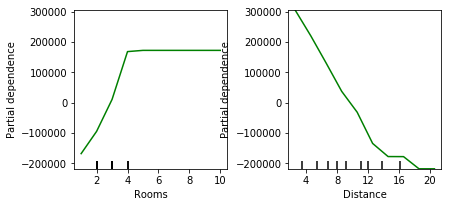

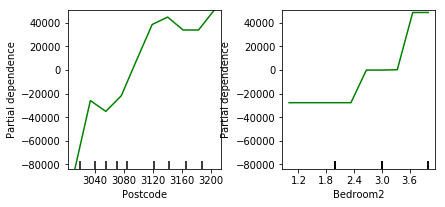

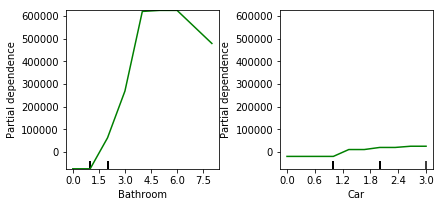

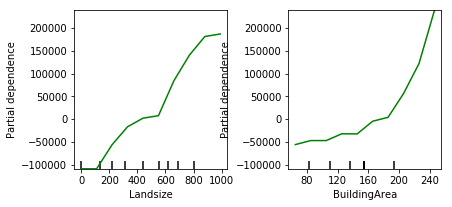

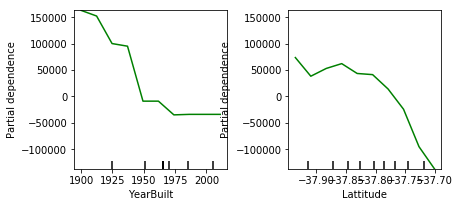

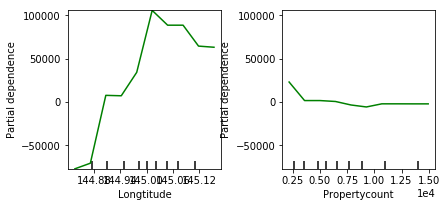

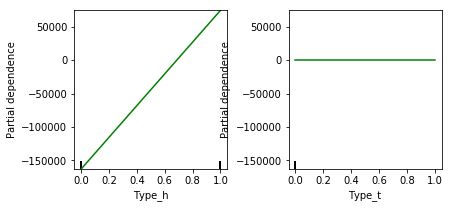

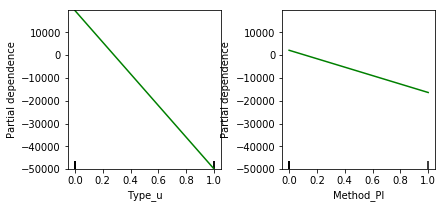

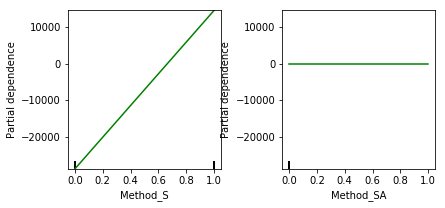

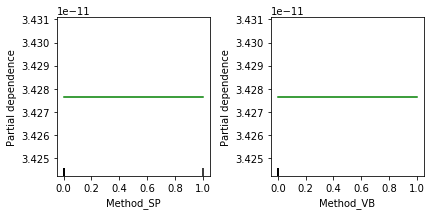

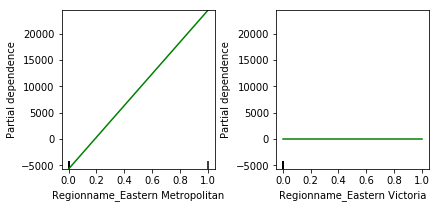

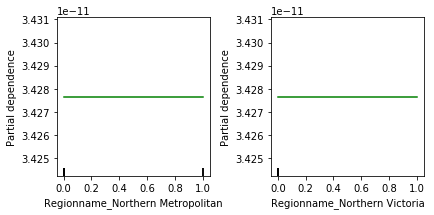

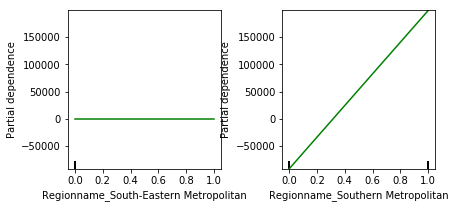

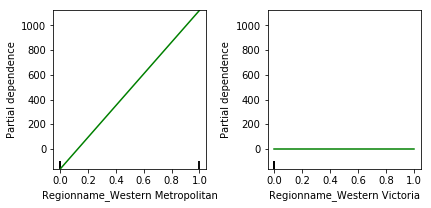

In [19]:
#Zmodyfikowalem kod, by bazowac na wczesniej stworzonych danych, po imputacji i po one-hot encodingu
#Partial Dependence pokazuje zaleznosc miedzy wartoscia cechy, a wartoscia targetu, przy marginalizacji pozostalych cech
#dzieki czemu mozna zobrazowac wplyw pojedynczych cech na wyniki, np wplyw wielkosci domu na jego cene
#z dokumentacji sklearn:Partial dependence plots show the dependence between the target function [2] and a set of ‘target’ features, marginalizing over the values of all other features (the complement features). Due to the limits of human perception the size of the target feature set must be small (usually, one or two) thus the target features are usually chosen among the most important features '''
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

cols_to_use = one_hot_encoded_training_predictors.columns #nazwy cech
features_size=len(cols_to_use)#wymiar, ile mamy cech

X=one_hot_encoded_training_predictors #X z uzwgledniniem one-hotow
y=train_y

my_model = GradientBoostingRegressor()#obliczenia z uzwgledniniem GradientBoostingRegressor
my_model.fit(X, y)

for i in range(0,features_size,2): #petla by wyplotowac wszystkie wykresy zaleznosci, po 2 wykresy
    my_plots = plot_partial_dependence(my_model, 
                                       features=[i,i+1], 
                                       X=X, 
                                       feature_names=cols_to_use, 
                                       grid_resolution=10)

# 5. Pipelines

In [20]:
#Pipelines pozwalaja zamknac proces transformacji i predykcji w jednym pipeline (wywolanie jedna linijka kilku transformacji i predykcji)
#mozliwe importy,make_pipeline automatycznie wypelnia nazwy, przy Pipeline trzeba je podac:
#from sklearn.pipeline import make_pipeline 
#from sklearn.pipeline import Pipeline
#Przyklad zapisu
'''
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier()),
    ])
predicted = pipeline.fit(Xtrain).predict(Xtrain)
# Now evaluate all steps on test set
predicted = pipeline.predict(Xtest)
'''

"\npipeline = Pipeline([\n    ('vect', CountVectorizer()),\n    ('tfidf', TfidfTransformer()),\n    ('clf', SGDClassifier()),\n    ])\npredicted = pipeline.fit(Xtrain).predict(Xtrain)\n# Now evaluate all steps on test set\npredicted = pipeline.predict(Xtest)\n"

In [21]:
#teraz juz pipeline z tutorialu
#zaczynam od poczatku z wczytaniem danych, by juz nie mieszac przy tworzeniu nowego pipeline
import pandas as pd 
from sklearn.model_selection import train_test_split #import modulu to podzialu zbioru na treningowy i testowy
from xgboost import XGBRegressor #import modelu XGBRegressor
from sklearn.pipeline import make_pipeline #import pipeline
from sklearn.impute import SimpleImputer #import imputatora

#Wczytanie danych, podzial na testowe i treningowe
data = pd.read_csv('../input/melbourne-housing-snapshot/melb_data.csv')
cols_to_use = ['Rooms', 'Distance', 'Landsize', 'BuildingArea', 'YearBuilt']
X = data[cols_to_use]
y = data.Price
train_X, test_X, train_y, test_y = train_test_split(X, y)

#Tworzenie pipeline
my_pipeline = make_pipeline(SimpleImputer(), XGBRegressor(n_estimators=1000, learning_rate=0.05, verbose=100, early_stopping_rounds=5))

#Uruchomienie pipeline
my_pipeline.fit(train_X, train_y)
predictions = my_pipeline.predict(test_X)

#Sprawdzenie bledu MAE
print("Mean Absolute Error dla pipeline z XGBRegressorem : " + str(mean_absolute_error(predictions, test_y)))

Mean Absolute Error dla pipeline z XGBRegressorem : 239004.9733546576


# 6. Cross Validation

In [22]:
#Cross validation polega na uruchomieniu treningu i sprawdzeniu jego jakosci na kilku roznych podzbiorach glownego datasetu
#Np. mamy 5 eksperymentow i bierzemy 80% jako zbior treningowy, a 20% jako walidacyjny -> sprawdzamy wynik
#i tworzymy kolejny zbior, bierzymy czesc starego zbioru treningowego jako nowy walidacyjny, a stary walidacyjny dodajemy do treningowego
#i tyle razy powtarzamy ile mamy eksperymentow

#Bardzo przydatny przy mniejszych datasetach, gdy wylaczenie zbioru testowego moze wplywac na wyniki uzyskiwane w treningu, a predykcja dla zbioru
#testowego moze byc niemiarodajna np.: zbior testowy zawiera szczegolne cechy, ktore w ogole nie wystepowaly w zbiorze treningowym
#CV pozwala dobierac i badac parametry
#Przy wiekszych datasetach wplyw ma dluzszy czas obliczen

#wykorzystuje pipeline z punktu 5-ego
#from sklearn.model_selection import GridSearchCV #inny model do CV
from sklearn.model_selection import cross_val_score #modul do CV
scores = cross_val_score(my_pipeline, X, y, scoring='neg_mean_absolute_error') #cross validation
print(scores) #ujemny wynik, bo w zalozeniu sklearn, im wiekszy wyniki tym lepszy model
print('Mean Absolute Error %2f' %(-1 * scores.mean())) #srednia z MAE z cross validation

[-287228.14206773 -286389.18885817 -280401.84624168]
Mean Absolute Error 284673.059056


# 7. Data Leakage

In [23]:
#Leaky Predictors - mamy z nimi doczynienia, gdy w treningu wykorzystujemy dane (cechy), ktore nie beda dostepne w predykcji, a ktore silnie wplywaja 
#uzyskiwany wynik i model np.: dane treningowe zawierajace informacje o chorobie i objawach danej osoby zawieraja takze informacje, czy zostal przepisany lek
#=>silna korelacja miedzy informacja czy zostal przepisany lek, a choroba => zly model, bo w predykcji nie bedzie informacji czy zostal przepisany lek
#Trzeba usunac takie cechy, do ktorych nie bedzie dostepu podczas predykcji i ktore charakteryzuja sie silna korelacja i zaburzaja model

#Leaky Validation Strategy - mamy z tym do czynienia, gdy przed podzialem na zbior treningowy i walidacyjny wykonujemy operacacje na danych imputacje
#fit, usrednianie, podczas ktorych zbior walidacyjny wplywa na wartosci w zbiorze treningowym
#=>uzyskujemy bardzo dobry wynik walidacji, ktory nie odpowiada rzeczywistosci
#=>przed jakimis dzialaniami na datasetach trzeba odizolowac zbior treningowy i walidacyjny/testowy, by nie wplywaly na siebie



In [24]:
#operujemy teraz na datsetcie AER_credit_card_data.csv
#wczytanie, przeglad wczytanego datasetu
import pandas as pd
data = pd.read_csv('../input/aer-credit-card-datacsv/AER_credit_card_data.csv', 
                   true_values = ['yes'], #podmienia yes na boolowski True
                   false_values = ['no']) #podmienia no na boolowski False
print(data.head())

   card  reports       age  income     share  expenditure  owner  selfemp  \
0  True        0  37.66667  4.5200  0.033270   124.983300   True    False   
1  True        0  33.25000  2.4200  0.005217     9.854167  False    False   
2  True        0  33.66667  4.5000  0.004156    15.000000   True    False   
3  True        0  30.50000  2.5400  0.065214   137.869200  False    False   
4  True        0  32.16667  9.7867  0.067051   546.503300   True    False   

   dependents  months  majorcards  active  
0           3      54           1      12  
1           3      34           1      13  
2           4      58           1       5  
3           0      25           1       7  
4           2      64           1       5  


In [25]:
data.shape #zwraca wymiar datesetu -> maly wymiar-> musimy zastosowac cross validation

(1319, 12)

In [26]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

y = data.card
X = data.drop(['card'], axis=1)

modeling_pipeline = make_pipeline(RandomForestClassifier())
cv_scores = cross_val_score(modeling_pipeline, X, y, scoring='accuracy')
#metryka accuracy zwraca stosunek ilosci poprawnych predykcji do sumy wszystkich predykcji
print("Cross-val accuracy: %f" %cv_scores.mean()) #zwrocenie sredniej accuracy

Cross-val accuracy: 0.981043


In [27]:
#Uzyskany wynik budzi watpliwosci, czy nie wynika z Leaky Predictors
#Sprawdzamy zaleznosc miedzy cecha expenditures i card

#df = pd.DataFrame({'AAA' : [4,5,6,7], 'BBB' : [10,20,30,40],'CCC' : [100,50,-30,-50], 'DDD' : [False,True,True,True]})
#df.AAA[~df.DDD]
#jesli wartosc data.card==True to zwraca wartosc  data.expediture (w danym wierszu)
expenditures_cardholders = data.expenditure[data.card]
#jesli wartosc (~data.card)==True to zwraca wartosc  data.expediture (w danym wierszu)
expenditures_noncardholders = data.expenditure[~data.card]

print('Udzial tych ktorzy nie mieli w wydatkow (?) wsrod posiadajcych karte: %.2f' \
      %(( expenditures_cardholders == 0).mean()))
print('Udzial tych ktorzy nie mieli wydatkow wsrod posiadajacych karte: %.2f' \
      %((expenditures_noncardholders == 0).mean()))

#100%, osob ktore nie mialo karty nie mialo tez wydatkow i zaledwie 2% tych co mieli karte nie mialo
#wydatkow
#=>SILNA KORELACJA miedzy posiadaniem karty, a wydatkami ->zly model
#->ktory glownie uwzglednia jedna ceche, a w predykcji moze jej nie byc!


Udzial tych ktorzy nie mieli w wydatkow (?) wsrod posiadajcych karte: 0.02
Udzial tych ktorzy nie mieli wydatkow wsrod posiadajacych karte: 1.00


In [28]:
#Uruchomienie modelu bez cech, ktore moga go zaburzac
potential_leaks = ['expenditure', 'share', 'active', 'majorcards'] #odrzucone cechy
X2 = X.drop(potential_leaks, axis=1) #wyrzucenie kolumn z tymi cechami
cv_scores = cross_val_score(modeling_pipeline, X2, y, scoring='accuracy') #cv z accuracy
print("Cross-val accuracy: %f" %cv_scores.mean())

#Widoczne gorsze accuracy, ale model lepiej bedzie sie sprawdzal w predykcji


Cross-val accuracy: 0.818819
